In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle competitions download -c g-research-crypto-forecasting

  0% 0.00/660k [00:00<?, ?B/s]
100% 660k/660k [00:00<00:00, 43.2MB/s]
  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 48.8kB/s]
  0% 0.00/444 [00:00<?, ?B/s]
100% 444/444 [00:00<00:00, 433kB/s]
 98% 1.00G/1.02G [00:11<00:00, 55.3MB/s]
100% 1.02G/1.02G [00:11<00:00, 95.4MB/s]
  0% 0.00/5.78k [00:00<?, ?B/s]
100% 5.78k/5.78k [00:00<00:00, 5.02MB/s]
  0% 0.00/406 [00:00<?, ?B/s]
100% 406/406 [00:00<00:00, 434kB/s]
 94% 89.0M/94.2M [00:01<00:00, 71.4MB/s]
100% 94.2M/94.2M [00:01<00:00, 63.0MB/s]


In [ ]:
!unzip \*zip && rm *.zip

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  supplemental_train.csv.zip
  inflating: supplemental_train.csv  

2 archives were successfully processed.


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [ ]:
assets = pd.read_csv("asset_details.csv")
assets.sort_values('Weight', ascending = False)

,Asset_ID,Weight,Asset_Name
2,1,6.779922,Bitcoin
5,6,5.894403,Ethereum
10,3,4.406719,Cardano
1,0,4.304065,Binance Coin
13,4,3.555348,Dogecoin
0,2,2.397895,Bitcoin Cash
6,9,2.397895,Litecoin
4,7,2.079442,Ethereum Classic
9,12,2.079442,Stellar
8,13,1.791759,TRON


In [ ]:
train = pd.read_csv("train.csv")
train['asset_name'] = train.Asset_ID.map(assets.set_index('Asset_ID').Asset_Name)
train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,asset_name
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218,Bitcoin Cash
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,Binance Coin
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643,Bitcoin
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922,EOS.IO
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264,Ethereum Classic


In [ ]:
import time
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

In [ ]:
bit = train[train.Asset_ID == 1].set_index('timestamp')
bit.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,asset_name
timestamp,,,,,,,,,,
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643,Bitcoin
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037,Bitcoin
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309,Bitcoin
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999,Bitcoin
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079,Bitcoin


In [ ]:
bit.isna().sum()

Asset_ID        0
Count           0
Open            0
High            0
Low             0
Close           0
Volume          0
VWAP            0
Target        304
asset_name      0
dtype: int64

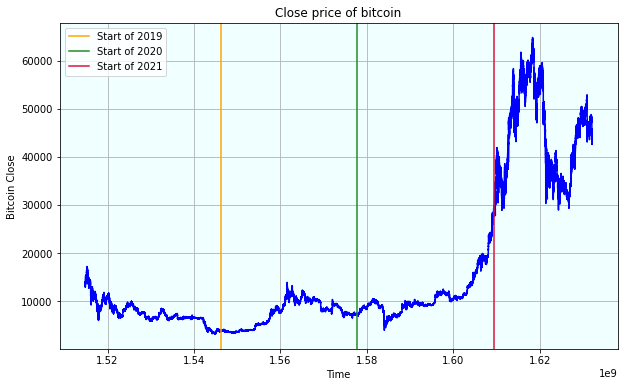

In [ ]:
f = plt.figure(figsize = (10,6))

ax = f.add_subplot(111)
ax.set_facecolor('azure')
plt.plot(bit['Close'], c = 'blue')
plt.axvline(x = 1546300800, label = 'Start of 2019', c = 'orange')
plt.axvline(x = 1577836800, label = 'Start of 2020', c = 'forestgreen')
plt.axvline(x = 1609459200, label = 'Start of 2021', c = 'crimson')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin Close')
plt.grid()
plt.title('Close price of bitcoin')

plt.show()

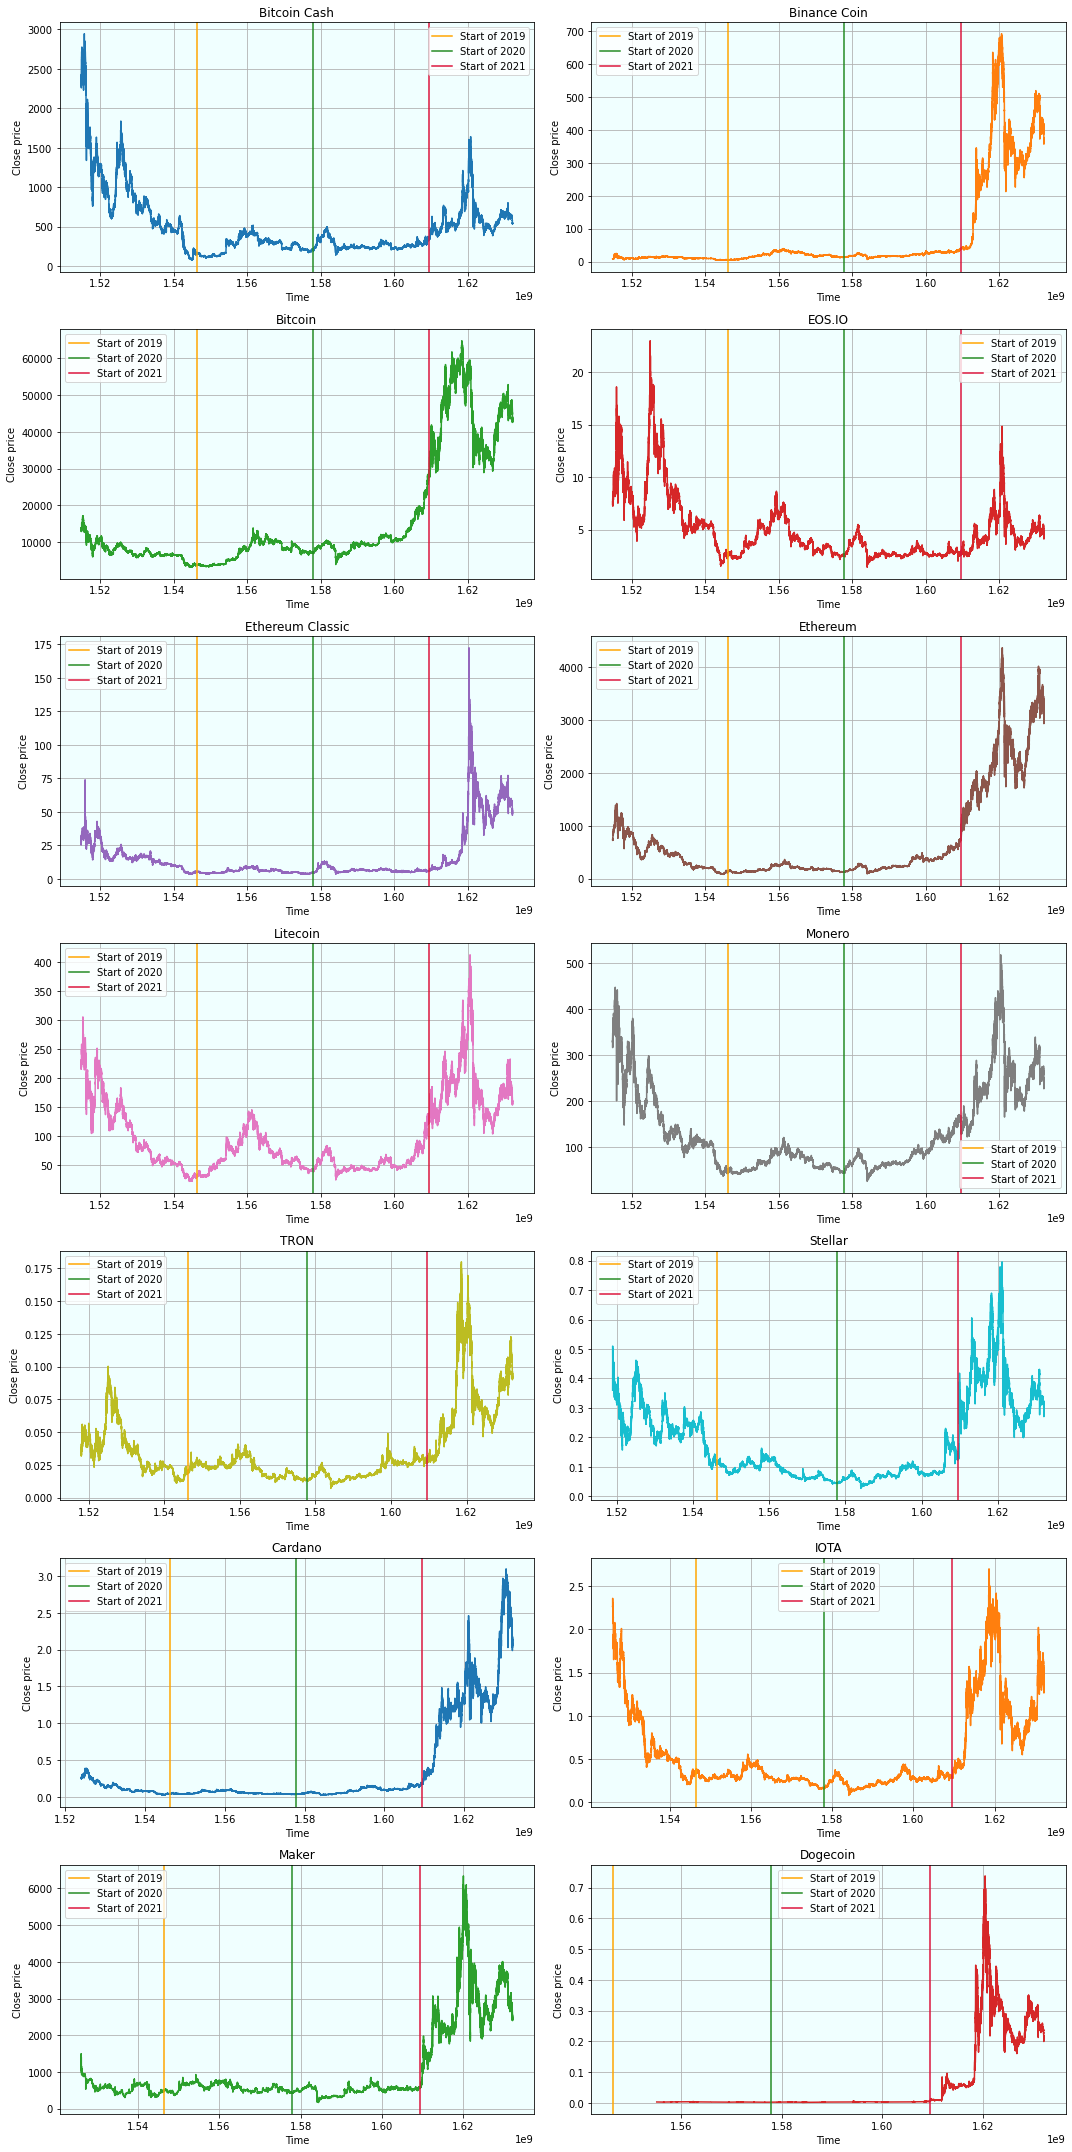

In [ ]:
cmap = sns.color_palette()
f = plt.figure(figsize = (15,30))

for ind,coin in enumerate(assets.Asset_Name.values):
    crypto = train[train.asset_name == coin].set_index('timestamp')
    ax = f.add_subplot(7,2,ind+1)
    ax.set_facecolor('azure')
    plt.plot(crypto['Close'], c = cmap[ind%10])
    plt.axvline(x = 1546300800, label = 'Start of 2019', c = 'orange')
    plt.axvline(x = 1577836800, label = 'Start of 2020', c = 'forestgreen')
    plt.axvline(x = 1609459200, label = 'Start of 2021', c = 'crimson')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Close price')
    plt.grid()
    plt.title(coin)
    
plt.tight_layout()
plt.show()

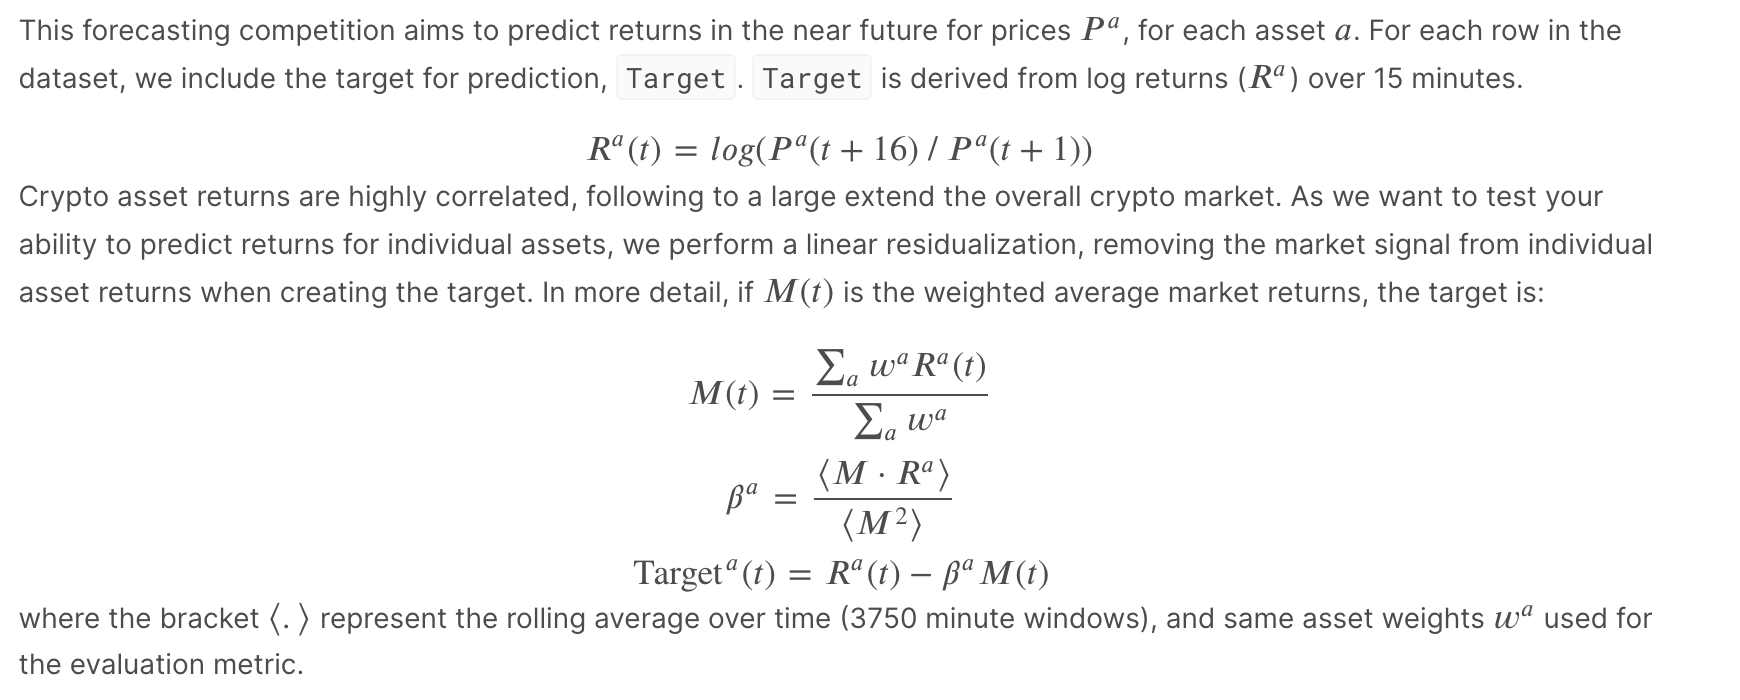

In [ ]:
btc = train[train["Asset_ID"]==1].set_index("timestamp") # Asset_ID = 1 for Bitcoin
eth = train[train["Asset_ID"]==6].set_index("timestamp") # Asset_ID = 6 for Ethereum
doj = train[train["Asset_ID"]==4].set_index("timestamp") # Asset_ID = 6 for Dojecoin

In [ ]:
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')

In [ ]:
# Select some input features from the trading data: 
# 5 min log return, abs(5 min log return), upper shadow, and lower shadow.

def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

X_btc = pd.concat([log_return(btc.VWAP,periods=5), log_return(btc.VWAP,periods=1).abs(), 
               upper_shadow(btc), lower_shadow(btc)], axis=1)
y_btc = btc.Target

X_eth = pd.concat([log_return(eth.VWAP,periods=5), log_return(eth.VWAP,periods=1).abs(), 
               upper_shadow(eth), lower_shadow(eth)], axis=1)
y_eth = eth.Target

X_doj = pd.concat([log_return(doj.VWAP,periods=5), log_return(doj.VWAP,periods=1).abs(), 
               upper_shadow(doj), lower_shadow(doj)], axis=1)
y_doj = doj.Target

In [ ]:
# select training and test periods
train_window = [totimestamp("01/05/2021"), totimestamp("30/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]

# divide data into train and test, compute X and y
# we aim to build simple regression models using a window_size of 1
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

X_doj_train = X_doj.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_doj_train = y_doj.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_doj_test = X_doj.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_doj_test = y_doj.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

In [ ]:
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)

X_doj_train_scaled = scaler.fit_transform(X_doj_train)
X_doj_test_scaled = scaler.transform(X_doj_test)

In [ ]:
from sklearn.linear_model import LinearRegression

#basic LR (one per asset)
lr = LinearRegression()
lr.fit(X_btc_train_scaled,y_btc_train)
y_pred_lr_btc = lr.predict(X_btc_test_scaled)

lr.fit(X_eth_train_scaled,y_eth_train)
y_pred_lr_eth = lr.predict(X_eth_test_scaled)

lr.fit(X_doj_train_scaled,y_doj_train)
y_pred_lr_doj = lr.predict(X_doj_test_scaled)

In [ ]:
#multiple input/output regression model
from sklearn.multioutput import MultiOutputRegressor

#concatenate X and y for both assets
X_both_train = np.concatenate((X_btc_train_scaled, X_eth_train_scaled), axis=1)
X_both_test = np.concatenate((X_btc_test_scaled, X_eth_test_scaled), axis=1)
y_both_train = np.column_stack((y_btc_train, y_eth_train))
y_both_test = np.column_stack((y_btc_test, y_eth_test))

# define the direct multioutput model and fit it
mlr = MultiOutputRegressor(LinearRegression())
mlr.fit(X_both_train,y_both_train)
y_pred_lr_both = mlr.predict(X_both_test)


In [ ]:
print('Testing score for LinReg: BTC', f"{np.corrcoef(y_pred_lr_btc, y_btc_test)[0,1]:.2f}", 
                                ', ETH', f"{np.corrcoef(y_pred_lr_eth, y_eth_test)[0,1]:.2f}")
print('Test score for Multiple Output LR: BTC', f"{np.corrcoef(y_pred_lr_both[:,0], y_btc_test)[0,1]:.2f}", 
                                                ', ETH', f"{np.corrcoef(y_pred_lr_both[:,1], y_eth_test)[0,1]:.2f}")

Testing score for LinReg: BTC -0.01 , ETH 0.02
Test score for Multiple Output LR: BTC 0.01 , ETH 0.05
